In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data = pd.read_csv("train.csv")

In [1]:
#총정리 함수
from sklearn.preprocessing import LabelEncoder,Binarizer

#NULL 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis =1, inplace = True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도 {0:0.4f}, 정밀도 {1:0.4f}, 재현율 {2:0.4f}, f1{3:0.4f}, AUC:{4:0.4f}'.format(accuracy, precision, recall,f1, roc_auc)) #{순서}

In [17]:
labels = data['Survived']
features = data.drop('Survived', axis = 1)

In [33]:
clf = LogisticRegression(max_iter = 500)

In [19]:
features = transform_features(features)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 11)

In [96]:
#fit 함수로 clf에 모델을 생성하고, predict method로는 X_test에 대한 예측값을 반환, 이를 실제 y_test와 비교
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_proba = clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[104  14]
 [ 13  48]]
정확도 0.8492, 정밀도 0.7742, 재현율 0.7869, f10.7805, AUC:0.9025


In [40]:
import numpy as np
pred_proba = clf.predict_proba(X_test)
pred = clf.predict(X_test)
print('pred_proba 결과 shape : {0}'.format(pred_proba.shape))
print('pred_proba 앞 3개만 추출\n', pred_proba[:3])
#axis: The axis along which the arrays will be joined. If axis is None, arrays are flattened before use. Default is 0.
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis = 1) 
print(pred_proba_result[:3])

pred_proba 결과 shape : (179, 2)
pred_proba 앞 3개만 추출
 [[0.46225185 0.53774815]
 [0.87878295 0.12121705]
 [0.877225   0.122775  ]]
[[0.46225185 0.53774815 1.        ]
 [0.87878295 0.12121705 0.        ]
 [0.877225   0.122775   0.        ]]


In [42]:

from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [47]:
custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binerizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binerizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도 0.8492, 정밀도 0.7742, 재현율 0.7869


In [54]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for customthreshold in thresholds:
        binarizer = Binarizer(threshold = customthreshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값', customthreshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값 0.4
오차행렬
[[98 20]
 [10 51]]
정확도 0.8324, 정밀도 0.7183, 재현율 0.8361
임계값 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 0.8492, 정밀도 0.7656, 재현율 0.8033
임계값 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 0.8492, 정밀도 0.7742, 재현율 0.7869
임계값 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 0.8659, 정밀도 0.8364, 재현율 0.7541
임계값 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 0.8771, 정밀도 0.8824, 재현율 0.7377


In [56]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = clf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

In [60]:
thr_index = np.arange(0, thresholds.shape[0],15) #
print('샘플 추출을 위한 임계값 배열의 index 10개', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))
print('샘플용 10개의 정밀도: ', np.round(precisions[thr_index],2))
print('샘플용 10개의 재현율: ', np.round(recalls[thr_index],2))

샘플 추출을 위한 임계값 배열의 index 10개 [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플용 10개의 정밀도:  [0.39 0.44 0.47 0.54 0.65 0.73 0.84 0.95 0.96 1.  ]
샘플용 10개의 재현율:  [1.   0.97 0.9  0.9  0.9  0.84 0.75 0.61 0.38 0.15]


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

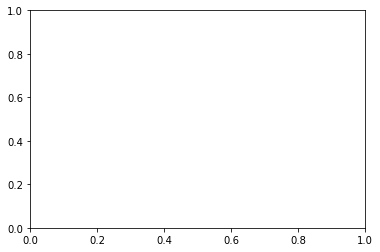

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


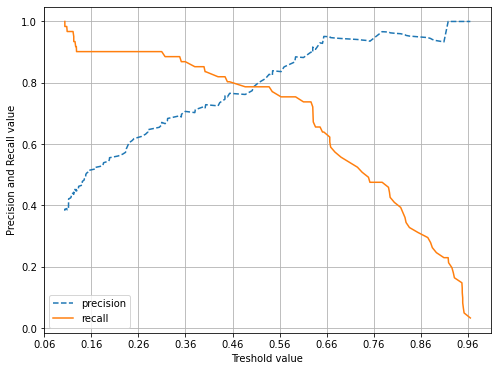

In [78]:
#시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker #눈금표시
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1) ##
    
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2)) #0.1 간격으로 그리겠다
    
    plt.xlabel('Treshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show

precision_recall_curve_plot(y_test, clf.predict_proba(X_test)[:,1])

In [83]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
f1

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값 0.4
오차행렬
[[98 20]
 [10 51]]
정확도 0.8324, 정밀도 0.7183, 재현율 0.8361, f10.7727
임계값 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 0.8492, 정밀도 0.7656, 재현율 0.8033, f10.7840
임계값 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 0.8492, 정밀도 0.7742, 재현율 0.7869, f10.7805
임계값 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 0.8659, 정밀도 0.8364, 재현율 0.7541, f10.7931
임계값 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 0.8771, 정밀도 0.8824, 재현율 0.7377, f10.8036


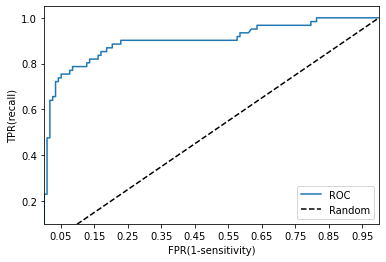

In [86]:
from sklearn.metrics import roc_curve

pred_proba_class1 = clf.predict_proba(X_test)[:,1]

def roc_curve_plot(y_test, pred_proba_calss1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1], [0,1], 'k--', label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0.1)
    plt.xlabel('FPR(1-sensitivity)'); plt.ylabel('TPR(recall)')
    plt.legend()
    
roc_curve_plot(y_test,pred_proba_class1)

In [87]:
from sklearn.metrics import roc_auc_score

pred_proba = clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
roc_score

0.9025423728813561

In [97]:
diabete_data = pd.read_csv('C://Users/user/Downloads/diabetes.csv')